# Stitching Demo
An explanation for the stitching process used in the master's thesis. 


NOTE: THIS NOTEBOOK DOES NOT PRODUCE CORRESPONDING RESULTS TO THE ONE IN THE MAIN BRANCH!!

## Imports
Imports the Python-files used that the Python files reside in.
Packages numpy, scipy, cv2, matplotlib and pillow are needed to run this code.
See the requirements.txt to install the needed environment.

In [1]:
import sys

sys.path.append("..")

from src.pre_process import *
from src.getImages import *
from src.estimateFeatures import *
from src.estimateCamera import *
from src.structure3D import *
from src.bundle_adjustment import *
from src.estimateShape import *
from src.projectStitch import *

## Pre-Process Images:
The stitched images have their resolution lowered and if needed are renamed. 
This step can be skipped.
The pre-processed images are saved to save on processing time, 
as doing this step in every run is very time-consuming.

NOTE: IMAGES ARE NOT INCLUDED IN THE REPOSITORY!!!!!!

In [2]:
# Location of the high-resolution images:
src_folder = r"..\data\raw\demo_1_high"
# Target folder for low-resolution images:
trg_folder = r"..\data\processed\demo_1"
# Location of the high-resolution chessboard:
src_folder2 = r"..\data\raw\Chessboard_high"
# Target folder for low-resolution chessboard:
trg_folder2 = r"..\data\processed\Chessboard"

# Renaming the files in the folder. Consecutive images need to be in alphabetical order.
# pre_process.rename_files(trg_folder)

# Lowering the resolution of the calibration chessboard and demo images. THESE NEED TO BE THE SAME RESOLUTION!!!!
lower_resolution_in_folder(
    folder_path=src_folder, output_folder=trg_folder, scale_percent=30
)
lower_resolution_in_folder(
    folder_path=src_folder2, output_folder=trg_folder2, scale_percent=30
)

Metadata updated for image '..\data\processed\demo_1\001.jpg'.
Image '001.jpg' resized and saved to '..\data\processed\demo_1\001.jpg'.
Metadata updated for image '..\data\processed\demo_1\002.jpg'.
Image '002.jpg' resized and saved to '..\data\processed\demo_1\002.jpg'.
Metadata updated for image '..\data\processed\demo_1\003.jpg'.
Image '003.jpg' resized and saved to '..\data\processed\demo_1\003.jpg'.
Metadata updated for image '..\data\processed\demo_1\004.jpg'.
Image '004.jpg' resized and saved to '..\data\processed\demo_1\004.jpg'.
Metadata updated for image '..\data\processed\demo_1\005.jpg'.
Image '005.jpg' resized and saved to '..\data\processed\demo_1\005.jpg'.
Metadata updated for image '..\data\processed\demo_1\006.jpg'.
Image '006.jpg' resized and saved to '..\data\processed\demo_1\006.jpg'.
Metadata updated for image '..\data\processed\demo_1\007.jpg'.
Image '007.jpg' resized and saved to '..\data\processed\demo_1\007.jpg'.
Metadata updated for image '..\data\processed\de

## Camera Calibration
The camera is calibrated using a known pattern, in this case a checkerboard pattern. This is done using 8x6 pattern. You can get one from: "https://markhedleyjones.com/projects/calibration-checkerboard-collection"

In [3]:
# Getting the calibration images:
images, img_shape = get_images(folderName=trg_folder2, pre_process=False)
# Obtaining the intrinsic matrix and distortion coefficients:
K, dist_coeffs = calibrate_camera(images=images, boardShape=(8, 6))

print("Obtained parameters:")
print(f"Calibration matrix: {K}")
print(f"Distortion Coefficients: {dist_coeffs}")

Obtained parameters:
Calibration matrix: [[478.0308738    0.         606.01672202]
 [  0.         475.38744446 262.66939298]
 [  0.           0.           1.        ]]
Distortion Coefficients: [[ 0.04028941 -0.07411382 -0.00488239  0.00728167  0.02354649]]


## Getting the Images:
The images that are to be stitched will be obtained and will be rectified using the previous distortion coefficients.

In [4]:
# Getting the images from
images, img_shape = get_images(folderName=trg_folder, pre_process=False)

# Applying distortion coefficients:
images = rectifyCamera(images=images, K=K, dist_coeffs=dist_coeffs)

# Taking only select number of images. (Some have bad overlap)
images = images[12:28]

## Obtaining Image Features and Descriptors and Matching:
The image SIFT-features and descriptors are obtained. After this they are matched and filtered based on the distance between one another. Only a select number of matches are kept.

In [5]:
# Obtaining the SIFT-Features and Descriptors:
keypoints_list, descriptors_list = getSIFTKeypointsAndDescriptors(images=images)

# Matching Descriptors:
matched_descriptors = matchDescriptors(
    descriptors_list=descriptors_list, distance_ratio_threshold=0.70, nMatches=50
)

# Obtaining the corresponding point matches:
points2d_list1, points2d_list2 = matchPoints(
    keypoints_list=keypoints_list, matched_descriptor_list=matched_descriptors
)

## Pose and Structure Estimation
The camera pose is obtained using the previously obtained matched points. These are then used to obtain the 3D-structure of the scene and refined using bundle adjustment.

In [6]:
# Estimation of the projection matrices:
P_list1, P_list2 = estimate_projection_matrices(
    points2d_list1=points2d_list1, points2d_list2=points2d_list2, K=K
)

# Obtaining of the 3D points:
points3d_list = triangulate_points_calibrated(
    P_list1=P_list1,
    P_list2=P_list2,
    points2d_list1=points2d_list1,
    points2d_list2=points2d_list2,
)


# Refining of the parameters:
(
    rvecs_list,
    tvecs_list,
    points3d_list,
) = bundle_adjustment(
    points3d_list=points3d_list,
    points2d_list=points2d_list2,
    P_list=P_list2,
    K=K,
    dist_coeffs=dist_coeffs,
    img_shape=img_shape,
)

## Radius Estimation and Cylindrical Warping:
The camera radius is estimated from the previously obtained 3D-points and the images are warped using it alongside extrinsic parameters.

In [7]:
# Estimating the cylinder radius:
cylinder_radius = estimate_cylinder_dimensions(
    triangulated_points=points3d_list, scaling_factor=100
)

# Cylindrical warping of images:
rectified_images_ba = rectify_images_cylindrical_ba(
    images=images, K=K, rvecs=rvecs_list, tvecs=tvecs_list, r=cylinder_radius
)

## Image Stitching and Results
Images are stitched using the cv2-package stitching class:

Stitched 16 images successfully!
Stitched images successfully!
Stitched 16 images successfully!
Stitched images successfully!


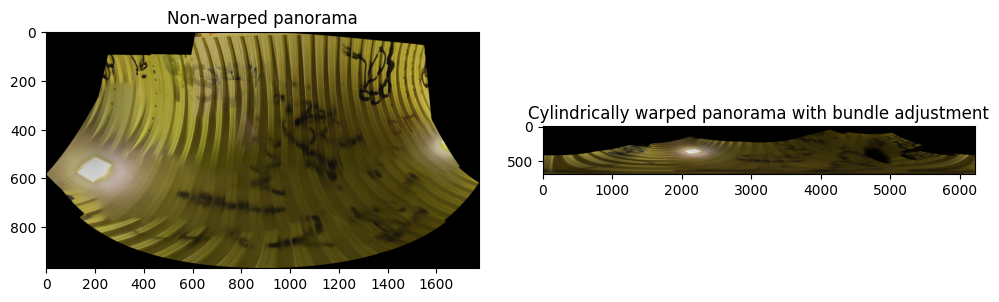

In [8]:
# CV2 Stitching:
panorama_no_warp_cv = stitch_images_cv_iterative(images=images, batch_size=len(images))
panorama_ba_cv = stitch_images_cv_iterative(
    images=rectified_images_ba, batch_size=len(images)
)

# Displaying of images:
displayImages(img1=panorama_no_warp_cv, img2=panorama_ba_cv)